In [115]:
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
  
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
       
        consumer_key = 'irNBsBncAReExSxJ0YwOg8sar'
        consumer_secret = 'UXaU2ykLNqBJGzeox8TvkCxNO7QQrgwbok5s8z7NexfeWpqeL0'
        access_token = '971451851026579456-sPb9pEosCIYJP8JE4mNxB0duGTa0qyi'
        access_token_secret = 'APznUi4hb4jN7Zi2ecGe8iS1v6og5IosxEu804kpAuoVK'
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
  
    def get_tweets(self, query, count = 10): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        tweets = [] 
  
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q=query,count=count) 
            
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
               
                parsed_tweet = {} 
  
                # saving text of tweet 
                parsed_tweet['text'] = tweet.text 
                
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 
               
          
            return tweets 
  
        except tweepy.TweepError as e: 
            print("Error : " + str(e)) 

def main(): 
    api = TwitterClient()  
    tweets = api.get_tweets(query="i", count = 10000) 
    print(tweets)
    
if __name__ == "__main__": 
    main() 

[{'text': "It's a Friday and I'm off duty...."}, {'text': "@JillAmeliaC I always get caught out with the 'Its better value' mentality and then proceed to eat the whole multi pack!"}, {'text': 'RT @sinyii_nf: Hun also talked about the delaying of Note2 concert, then carry on to thank fans for always supporting them and waiting for…'}, {'text': 'yo... my ex use to complain about 10 minutes &amp; gas. I swear I thought I was the only one. Preach sis “don’t settle”… https://t.co/lIUM1o9GM3'}, {'text': '@Hardykat1027 I AM CALM WHATCHUTALKINGABOUTWILLIS!?!'}, {'text': 'RT @Vetteleclerc: Ricciardo about all the bad luck he had this year:\n\n"A bad day for me would still be good for many other people. When I w…'}, {'text': '@3hobbits @TrinityLiveUK2 Now, THAT is a line.... if anybody can walk it though, it’s you! I have every faith in you!'}, {'text': 'RT @jholjhaalsir: @Pun_Starr I want ₹14,99,995 first, then I will meet Modi.'}, {'text': 'RT @hsanwong2: I don’t regret my past. I just regret 

In [116]:
from collections import Counter, defaultdict
from datetime import datetime
from sklearn.decomposition import PCA

import csv
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns;  sns.set()
import time
import twitter

% matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(1000)

In [117]:
self_screen_name = 'bala_io'          

# Keep appending data
fof_filename     = "edges.csv"          # 'Alters' and their Source->Sink Edges. 
cache_filename   = "cache.csv"          # local cache of (TwitterId, FullName, UserName)

# One-time-use files
binaryMap_filename = "binaryMap.csv"   
cluster_filename   = "results.csv"

In [118]:

api = twitter.Api('irNBsBncAReExSxJ0YwOg8sar', 'UXaU2ykLNqBJGzeox8TvkCxNO7QQrgwbok5s8z7NexfeWpqeL0','971451851026579456-sPb9pEosCIYJP8JE4mNxB0duGTa0qyi', 'APznUi4hb4jN7Zi2ecGe8iS1v6og5IosxEu804kpAuoVK')
api

In [119]:
# 'Self' and Friends of Self

self_node    =  api.GetUser(screen_name = self_screen_name)    
self_node_id =  str(self_node.id)                      # Twitter Id of Self

friends_of_self = api.GetFriendIDs(user_id = self_node_id, 
                                   screen_name = self_screen_name , 
                                   stringify_ids = True)
index = [self_node_id] + friends_of_self

In [120]:
# GetFriendIDs() API call is rate-limited at 15 req / 15 min 

# For each of the list of nodes, fetch the list of nodes it follows, append to file

def update_FoF_File(fileName, to_fetch_list):
    
    with open(fileName, 'a') as f:
        apiReqCount = 0
        c=0
        for node in to_fetch_list:
            friends_of_node = api.GetFriendIDs(user_id = node,  stringify_ids = True) 
            '''
            c+=1
            if(c==14):
                break
            '''
            row = ','.join([str(i) for i in [node] +  friends_of_node ]) + "\n"
            f.write(row) 
            
            apiReqCount += 1
            
            if (apiReqCount == 10): 
                apiReqCount = 0
                
                print("Off to Sleep :)")
                time.sleep(15*60 + 10)
            

In [121]:
# parse FoF file and return list of nodes, for whom source->sink Edges are already there.

def getFinishList(fileName):
        
    if not os.path.isfile(fileName):
        return [] 
    with open(fileName, 'r') as f:
        return [ row.strip().split(',')[0] for row in f ]  # 1st entry is a user

In [122]:
# Ego-network as adjacency-matrix
# Parses FoF file in order of index, create list of adjacencies as 0 | 1
# Writes to File. Adjacency-matrix in Row_follows_Column format

def updateBinaryMapFile(fof_filename, binaryMap_filename, index):
    
    with open(fof_filename, "r") as f:
        stripped_f = (line.replace('\r', '') for line in f)
        reader = csv.reader(stripped_f)
        fof_dict = {line[0]: line[1:] for line in reader 
                    if line[0] in index}   # dict of node:his_followers
        if self_node_id not in fof_dict:
            fof_dict[self_node_id] = index[1:]             # dict of Self
    
    bool_list = []
    print(fof_dict)
    for user in index:
        try:
            user_friends = set( fof_dict[user] )
        except:
            user_friends=set()
        bool_row = [item in user_friends for item in index]  # for each, fill T/F 
        bool_list.append(bool_row)
    
    int_nparray = np.array(bool_list) + 0                    # Bool to int

    binaryMap_rfc = pd.DataFrame(data = int_nparray, columns= index, index = index)
    binaryMap_rfc.to_csv(binaryMap_filename)

In [123]:
# For list of Ids, fetch Profile details. If not in Offline file, make an API call
# Returns ['UserName', 'FullName', 'Followers_count', 'Friends_count', 'Location', 'Created_at']
# UsersLookup API 100 Ids/request

def lookup_in_cache(friendsIdsList):

    cache, delta_cache = pd.DataFrame(), pd.DataFrame()
    UserNameList, namesList     = [], []
    followers_count, friends_count = [], []
    location, created_at           = [], []
    
    if os.path.isfile(cache_filename):
        cache = pd.read_csv(cache_filename, skip_blank_lines=True,
                        dtype={'Ids':str, 'Friends_count':int, 'Followers_count':int})
        cache.set_index('Ids', inplace=True)
        to_fetch_list = list ( set (friendsIdsList) - set(cache.index) )
    else :        
        to_fetch_list = friendsIdsList   
    
    i = 0
    while (i < len(to_fetch_list) * 1./100):   
        print("... Cache-Miss for " + str(len(to_fetch_list)) +  " nodes. Updating Cache...")
        low, high = i * 100, min( len(to_fetch_list), (i+1)*100 )  # UsersLookup api
        twitterObjectsList = api.UsersLookup(user_id = to_fetch_list[low:high])    
        
        temp = zip(*[( tempObject.screen_name,        #ScreenName
                      tempObject.name,                #Name
                      tempObject.followers_count,     #Followers
                      tempObject.friends_count,       #Friends
                      tempObject.location,            #Location
                      tempObject.created_at           #CreatedAt
                     ) for tempObject in twitterObjectsList])
        temp = list(temp)
        
        UserNameList    += list(temp[0])
        namesList       += list(temp[1])
        followers_count += list(temp[2])
        friends_count   += list(temp[3])
        location        += list(temp[4])
        created_at      += list(temp[5])
        
        i = i + 1       
    
    if len(to_fetch_list) > 0:
        delta_cache  = pd.DataFrame({'UserName':UserNameList,
                                     'FullName':namesList,
                                     'Ids': to_fetch_list,
                                     'Followers':followers_count,
                                     'Friends': friends_count,
                                     'Location':location,
                                     'Created':created_at})
        
        delta_cache['Created'] = delta_cache['Created'].apply(lambda x: 
                                                datetime.strptime(
                                                    re.sub(r"\+[0-9]* ", "",x),'%c').
                                                strftime("%b-%Y"))
    
        delta_cache.set_index('Ids', inplace=True, drop = True)
        cache = cache.append(delta_cache)
        cache.to_csv(cache_filename)        

    return cache.loc[friendsIdsList]

In [124]:
# Display cluster-wise most-influential users, for the given clustering algo

def top_nodes_in_cluster(df, cluster_algo, n_clusters):
    dummy_df = pd.DataFrame()

    for i in range(n_clusters):
        nodes_in_cluster = list( df [df[cluster_algo] == i ]['FullName'] )     
        if len(nodes_in_cluster) >= 10:            # show only clusters of size > 10        
            col_name           = str(i) + " : " + str(len(nodes_in_cluster)) + " Ids"
            dummy_df[col_name] = nodes_in_cluster[:10]      
    
    return dummy_df

In [125]:
# identify 20 friends to follow after aggregating friends followed by top 50% in list

def discover_Friends_toFollow(ids_of_interest, friend_list, prop = .5, count = 20):    
    
    ids_of_interest  = ids_of_interest[:int(len(ids_of_interest) * prop)]
    
    if self_node_id in ids_of_interest:
        ids_of_interest.remove(self_node_id)

    print("'Who-To-Follow' reco after looking at %3d friends' friends:" %(len(ids_of_interest)))
    
    with open(fof_filename) as f:
        reader = csv.reader(f)
        fof_dict = {row[0]:row[0:] for row in reader}  # dict of node:her_followers

    friendsToFollow = []
    for id in ids_of_interest:
        try:
            friendsToFollow += list (set(fof_dict[str(id)])  - set(friend_list) ) 
        except:
            continue
        
    friendsToFollow = Counter(friendsToFollow).most_common(count)    
    tuples_list = list(zip(*friendsToFollow) )

    topFriendsToFollowDF = pd.DataFrame()
    topFriendsToFollowDF['Ids'] = list(tuples_list[0])
    topFriendsToFollowDF['Freq'] = list(tuples_list[1])
    topFriendsToFollowDF.set_index('Ids', drop = True, inplace = True)              
    index = topFriendsToFollowDF.index

    topFriendsToFollowDF = topFriendsToFollowDF.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)

    return topFriendsToFollowDF

In [126]:
# For the list of nodes I follow, fetch their friends-list

fof_finish_list   = getFinishList(fof_filename )        # Completed nodes
fof_to_fetch_list = list ( set(friends_of_self) - set(fof_finish_list) )  # Pending nodes

print( str(len(fof_to_fetch_list)) + " out of " + str(len(index)  - 1) + 
      " Friends details to be fetched")

336 out of 404 Friends details to be fetched


In [127]:
# For the remaining nodes, populate their details in fof_file
#update_FoF_File(fof_filename, fof_to_fetch_list) 

# Build the adjacency matrix in terms of 0 and 1 (if there is an edge)
updateBinaryMapFile(fof_filename, binaryMap_filename, index)

{'12451812': ['26906309', '1058050594638712832', '857728301703471104', '3983691072', '271516623', '485016086', '50940456', '105705196', '36153601', '997629601', '12087912', '358695512', '133388615', '1040538994331840512', '326511843', '955693466893209601', '991451', '25763', '811350', '2978637351', '2838201826', '71604006', '4071001', '19387570', '16890685', '390233181', '427089628', '42587296', '3222005004', '59918812', '12935692', '1012802414552997888', '13929162', '17773446', '636923', '1566661', '963099367124226050', '2460047754', '47209050', '17977144', '737854279810056192', '37975275', '264165471', '774642558853009408', '3600790875', '996124017990889472', '314180537', '34072375', '3032174892', '353206839', '756501542', '765680033788669952', '661403', '30563975', '305398683', '19188700', '26149295', '542666345', '963121', '93841311', '20405474', '3363584909', '772866810127409152', '3422200198', '27577824', '732964902273306624', '15143065', '9670742', '3070985713', '17088394', '191

In [128]:
# Read adj-matrix into df. Cell MxN is 1 iff node in Mth row follows node in Nth column 
binaryMap_rfc = pd.read_csv(binaryMap_filename, skip_blank_lines=True, index_col = 0)
print(binaryMap_rfc.shape)


outlinks_count = binaryMap_rfc.sum(axis = 1)   # horizontal-sum to count outlinks
inlinks_count = binaryMap_rfc.sum(axis = 0)   # vertical-sum to count inlinks

(405, 405)


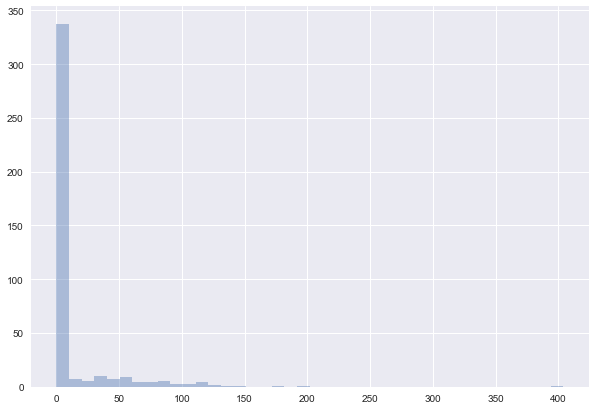

In [129]:
# Histogram of number of OutLinks per node, within ego-network
sns.distplot(outlinks_count, bins = len(index)//10, kde=False);

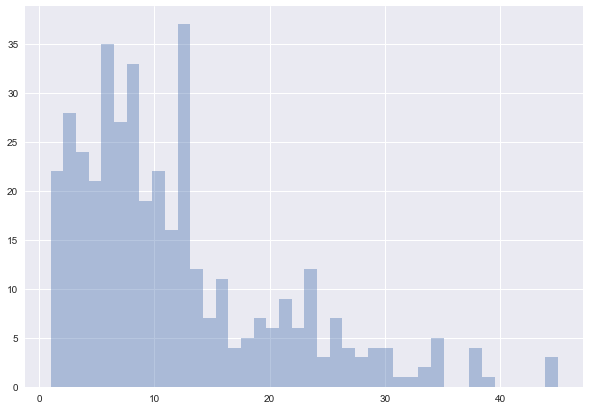

In [130]:
# Histogram of number of InLinks per node, within ego-network
sns.distplot(inlinks_count, bins = len(index)//10, kde=False);

In [131]:

binaryMap_cfr      = binaryMap_rfc.transpose()            # column-values: Outlinks
binaryMap_cfr_norm = binaryMap_cfr / binaryMap_cfr.sum(axis = 0)
colStochMatrix = np.matrix( binaryMap_cfr_norm.fillna(0)) # column-stochastic-matrix

In [132]:

pageRankVector = np.matrix([1.0/len(index)] *  len(index)) # iniitialize page-rank-vector 
pageRankVector = pageRankVector.transpose()                # transpose to column-vector

In [133]:
# PageRank algo: Power Iteration to solve Markov transition matrix 
# refer this     : http://setosa.io/blog/2014/07/26/markov-chains/index.html

beta = 0.85
epsilon = 999
iteration = 0
while epsilon > (1.0/(10**16)):
    pageRankVectorUpdating = colStochMatrix * pageRankVector * beta 
    
    # re-insert leaked page-ranks
    S = np.array(pageRankVectorUpdating).sum()                      
    pageRankVectorUpdated = pageRankVectorUpdating + (
        1 - S) * (1.0/len(index)) * np.ones_like(len(index))
    
    # compute the squared-difference and check for convergence
    error = np.array(pageRankVectorUpdated - pageRankVector)
    epsilon = np.sqrt((error *  error).sum())   
    iteration = iteration + 1
    pageRankVector = pageRankVectorUpdated    
    
print( "Sum of Page-Rank Scores: " + str(pageRankVector.sum()) + 
      "\nConverged in " + str(iteration) + " iterations")

Sum of Page-Rank Scores: 1.0
Converged in 16 iterations


In [134]:
# Collect the results

results_df = pd.DataFrame()
results_df['Ids'], results_df['PageRank'] = index, pageRankVector
results_df['Inlinks'], results_df['Outlinks'] = list(inlinks_count), list(outlinks_count)
results_df = results_df.set_index('Ids', drop = True )

results_df = results_df.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)
results_df = results_df[['PageRank','UserName', 'FullName', 'Inlinks' , 'Outlinks',
                         'Followers','Friends', 'Location', 'Created' ]]

In [135]:
results_df.fillna('').sort_values(by = 'PageRank', ascending =False).set_index('FullName').head(10)


,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created
FullName,,,,,,,,
Tim O'Reilly,0.003983,timoreilly,45,0,1809002,1944,"Oakland, CA",Mar-2007
Reid Hoffman,0.003939,reidhoffman,44,0,505776,577,new world of work,Oct-2006
Nate Silver,0.003892,NateSilver538,39,0,3170661,1122,New York,Aug-2008
Marc Andreessen,0.003839,pmarca,45,0,706527,18801,"Menlo Park, CA",May-2007
Bill Gates,0.003725,BillGates,38,0,45995911,201,"Seattle, WA",Jun-2009
Elon Musk,0.003621,elonmusk,38,0,23437720,76,,Jun-2009
Paul Graham,0.003572,paulg,38,0,1057402,330,,Aug-2010
Fred Wilson,0.003356,fredwilson,38,0,648923,1241,New York City,Mar-2007
OM,0.003336,om,34,101,1370499,1388,"ÜT: 37.795917,-122.39966",Jul-2006


In [136]:
dummy_df = pd.DataFrame()
temp_df  = results_df.sort_values( by = 'PageRank', ascending =False)

for i in range(10):
    dummy_df[i] = list (temp_df [10*i : 10* i + 10]['FullName'])
dummy_df

,0,1,2,3,4,5,6,7,8,9
0,Tim O'Reilly,Vinod Khosla,Ben Horowitz,Bill Gurley,Brad Stone,Bill Gross,Keith Rabois,Emily Chang,steve blank,Jeff Jordan
1,Reid Hoffman,WIRED,Steven Levy,Jessica Lessin,Sundar Pichai,Naval,Y Combinator,Tim Ferriss,Bret Taylor,Brian Chesky
2,Nate Silver,Sam Altman,Eric Schmidt,Lessig,Bradley Horowitz,Dan Primack,Glenn Greenwald,Jeff Dean,Tony Fadell,Ben Thompson
3,Marc Andreessen,Kara Swisher,Benedict Evans,Chris Anderson,MIT Technology Review,Hilary Mason,Matt Cutts,Gabe Rivera,GV,zeynep tufekci
4,Bill Gates,Steven Sinofsky,Pierre Omidyar,Andrew Ng,Steve Case,Jonah Peretti,Josh Elman,Stanford Business,Yann LeCun,Bryce Roberts
5,Elon Musk,Ev Williams,John Lilly,danah boyd,Walt Mossberg,Steven Pinker,Paul Kedrosky,Recode,Edward Tufte,Sebastian Thrun
6,Paul Graham,Chris Anderson,John Markoff,jason 🦄 🇯🇵 ❤️,Nick Bilton,Andrew Chen,Steven Johnson,Clayton Christensen,Wes McKinney,Balaji S. Srinivasan
7,Fred Wilson,Chris Sacca,DAVE MORIN,👨🏻‍💻☕️,a16z,John Collison,Sarah Lacy,Paul Buchheit,Chamath Palihapitiya,Neil deGrasse Tyson
8,OM,Joi Ito,Edward Snowden,Max Levchin,Josh Kopelman,Mark Suster,David Sacks,Startup L. Jackson,Kleiner Perkins,Philip Kaplan
9,TechCrunch,Chris Dixon,dj patil,Patrick Collison,Jimmy Wales,Fei-Fei Li,Garry BUIDL Tan,Kevin Weil,Ben Hamner,First Round


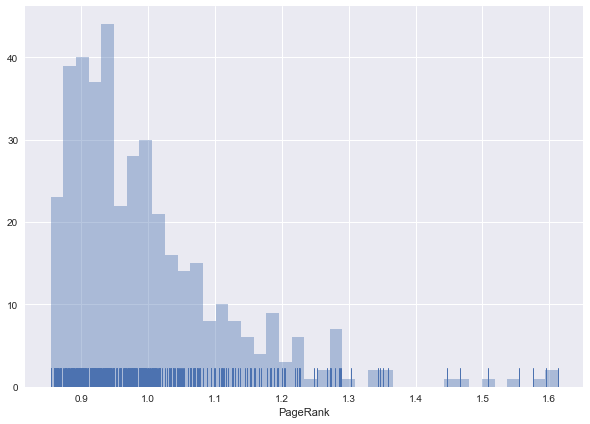

In [137]:
pageRank_to_plot = len(index) * results_df["PageRank"]
sns.distplot(pageRank_to_plot, kde=False, rug=True, bins = len(index)//10);

In [138]:
n_clusters = min( int( round(np.sqrt(len(index)/2)) ), 10 ) # not more than 10 clusters
print(n_clusters)

10


In [139]:
from sklearn.cluster import KMeans
est = KMeans(max_iter = 100000, n_clusters = n_clusters, n_init = 200, init='k-means++')  
results_df['kmeans'] = est.fit_predict(binaryMap_cfr)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False),  'kmeans', n_clusters)

,0 : 39 Ids,1 : 46 Ids,2 : 41 Ids,3 : 87 Ids,5 : 16 Ids,6 : 38 Ids,7 : 32 Ids,8 : 41 Ids,9 : 58 Ids
0,Fred Wilson,Andrew Ng,Steven Sinofsky,Neil deGrasse Tyson,TechCrunch,Hilary Mason,Steven Pinker,Edward Snowden,Richard H Thaler
1,OM,Fei-Fei Li,jason 🦄 🇯🇵 ❤️,Christopher Soghoian,WIRED,Wes McKinney,Stanford Business,Glenn Greenwald,Michael E. Driscoll
2,Vinod Khosla,Jeff Dean,Patrick Collison,Bob Sutton,Chris Anderson,Ben Hamner,Clayton Christensen,Edward Tufte,Tristan Harris
3,Sam Altman,Yann LeCun,Jonah Peretti,WikiLeaks,Joi Ito,zeynep tufekci,Atul Gawande,Hacker News,Anthony Goldbloom
4,Kara Swisher,Sebastian Thrun,Andrew Chen,Dan Kaminsky,Pierre Omidyar,Peter Skomoroch,Stanford University,EFF,Paul Ford
5,Ev Williams,François Chollet,John Collison,Martin Varsavsky,John Markoff,Jeff Hammerbacher,IDEO,Werner Vogels,Shane Parrish
6,Chris Sacca,Google AI,Keith Rabois,David Rowan,Lessig,Nathan Yau,John Hagel,Jessica Livingston,Michael Bernstein
7,Chris Dixon,Microsoft Research,Matt Cutts,Andrew Gelman,Chris Anderson,Mike Olson,Tom Hulme,Frank Chen,Fernanda Viégas
8,Ben Horowitz,Kate Crawford,Josh Elman,Deb Roy,danah boyd,Hadley Wickham,Adam Grant,DHH,Martin Wattenberg
9,Steven Levy,Monica Rogati,Garry BUIDL Tan,Cory Johnson,MIT Technology Review,Drew Conway,Erik Brynjolfsson,Max Roser,John Carmack


In [140]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=n_clusters,  n_init = 500,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral.fit(binaryMap_cfr)
results_df['spectral'] = spectral.labels_.astype(np.int)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'spectral', n_clusters)

,0 : 39 Ids,1 : 54 Ids,2 : 18 Ids,4 : 45 Ids,5 : 26 Ids,6 : 151 Ids,7 : 17 Ids,8 : 25 Ids,9 : 24 Ids
0,WIRED,Steven Sinofsky,TechCrunch,Microsoft Research,Andrew Ng,Tim O'Reilly,Reid Hoffman,Wes McKinney,Mike Olson
1,Chris Anderson,Steven Levy,Vinod Khosla,Monica Rogati,Fei-Fei Li,OM,Nate Silver,Hadley Wickham,Michael E. Driscoll
2,Joi Ito,John Lilly,Benedict Evans,Frank Chen,François Chollet,John Markoff,Marc Andreessen,John Myles White,Anthony Goldbloom
3,Pierre Omidyar,jason 🦄 🇯🇵 ❤️,👨🏻‍💻☕️,Michael Bernstein,Demis Hassabis,Edward Snowden,Bill Gates,Andreas Mueller,Kaggle
4,Lessig,Patrick Collison,Sundar Pichai,Arvind Narayanan,Xavier🎗🤖🏃,dj patil,Elon Musk,Olivier Grisel,John D. Cook
5,Chris Anderson,Brad Stone,Walt Mossberg,Dan Ariely,John Platt,danah boyd,Paul Graham,Sean J. Taylor,Mike Bostock
6,MIT Technology Review,Bradley Horowitz,a16z,Fernanda Viégas,Andrej Karpathy,Max Levchin,Fred Wilson,Jeffrey Heer,Shane Conway
7,Jimmy Wales,Steve Case,Naval,Martin Wattenberg,Richard,Hilary Mason,Sam Altman,Ben Lorica 罗瑞卡,Lukas Biewald
8,Bill Gross,Nick Bilton,Mark Suster,Ian Goodfellow,Oren Etzioni,Glenn Greenwald,Kara Swisher,Lynn Cherny,Brad Voytek
9,Steven Pinker,Josh Kopelman,Y Combinator,Kenneth Cukier,Stanford NLP Group,Matt Cutts,Ev Williams,Joshua Bloom,Harlan Harris


In [141]:
results_df [results_df['spectral'].isin([1])].sort_values(by = 'PageRank', ascending =False).set_index('FullName').head()

,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created,kmeans,spectral
FullName,,,,,,,,,,
Steven Sinofsky,0.003173,stevesi,28,117,165745,4593,USA,Feb-2008,2,1
Steven Levy,0.003083,StevenLevy,29,0,108740,767,New York City,Mar-2007,0,1
John Lilly,0.003020,johnolilly,26,0,190212,615,NaN,Feb-2007,0,1
jason 🦄 🇯🇵 ❤️,0.002923,Jason,22,0,294211,7611,94107,Aug-2006,2,1
Patrick Collison,0.002907,patrickc,27,0,97759,2107,patrick@stripe.com,Apr-2007,2,1


In [142]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50).fit(binaryMap_cfr)
results_df['affinity'] = af.labels_
n_clusters_affinity = len(af.cluster_centers_indices_)

print(str(n_clusters_affinity) + " affinity clusters.")

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'affinity', n_clusters_affinity)

9 affinity clusters.


,0 : 135 Ids,1 : 54 Ids,2 : 80 Ids,3 : 23 Ids,4 : 20 Ids,5 : 24 Ids,6 : 27 Ids,7 : 30 Ids,8 : 12 Ids
0,Edward Snowden,Andrew Ng,danah boyd,Hilary Mason,TechCrunch,WIRED,Sam Altman,Tim O'Reilly,Reid Hoffman
1,Glenn Greenwald,Fei-Fei Li,Ben Hamner,Wes McKinney,Vinod Khosla,Chris Anderson,Steven Sinofsky,Nate Silver,Marc Andreessen
2,Edward Tufte,Jeff Dean,Mike Olson,zeynep tufekci,MIT Technology Review,Pierre Omidyar,Benedict Evans,OM,Bill Gates
3,Neil deGrasse Tyson,Yann LeCun,Tom Hulme,Hadley Wickham,Walt Mossberg,Lessig,DAVE MORIN,Joi Ito,Elon Musk
4,Hacker News,Sebastian Thrun,Richard H Thaler,Drew Conway,a16z,Jimmy Wales,Bill Gurley,Steven Levy,Paul Graham
5,Atul Gawande,François Chollet,Michael E. Driscoll,John Myles White,Naval,Steven Pinker,Max Levchin,Eric Schmidt,Fred Wilson
6,Stanford University,Peter Skomoroch,Tristan Harris,Sean J. Taylor,Mark Suster,Steven Johnson,Patrick Collison,John Lilly,Kara Swisher
7,EFF,Jeff Hammerbacher,Monica Rogati,Bret Victor,Y Combinator,Stanford Business,Steve Case,John Markoff,Ev Williams
8,Adam Grant,Nathan Yau,Xavier🎗🤖🏃,Jeffrey Heer,Tim Ferriss,Clayton Christensen,Nick Bilton,dj patil,Chris Sacca
9,Kate Crawford,Google AI,Kevin Kelly,Ben Lorica 罗瑞卡,Recode,IDEO,Josh Kopelman,Jessica Lessin,Chris Dixon


In [143]:
pca = PCA(n_components=3)
Xproj = pca.fit_transform(binaryMap_cfr)

results_df['dim1'] = Xproj[:,0]
results_df['dim2'] = Xproj[:,1]
results_df['dim3'] = Xproj[:,2]

results_df = results_df.sort_values( by = 'PageRank', ascending =False)
results_df.to_csv(cluster_filename)

print("Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]")
print(pca.explained_variance_, pca.explained_variance_ratio_)

Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]
[2.04359574 0.64278777 0.39525665] [0.24186192 0.07607468 0.04677908]


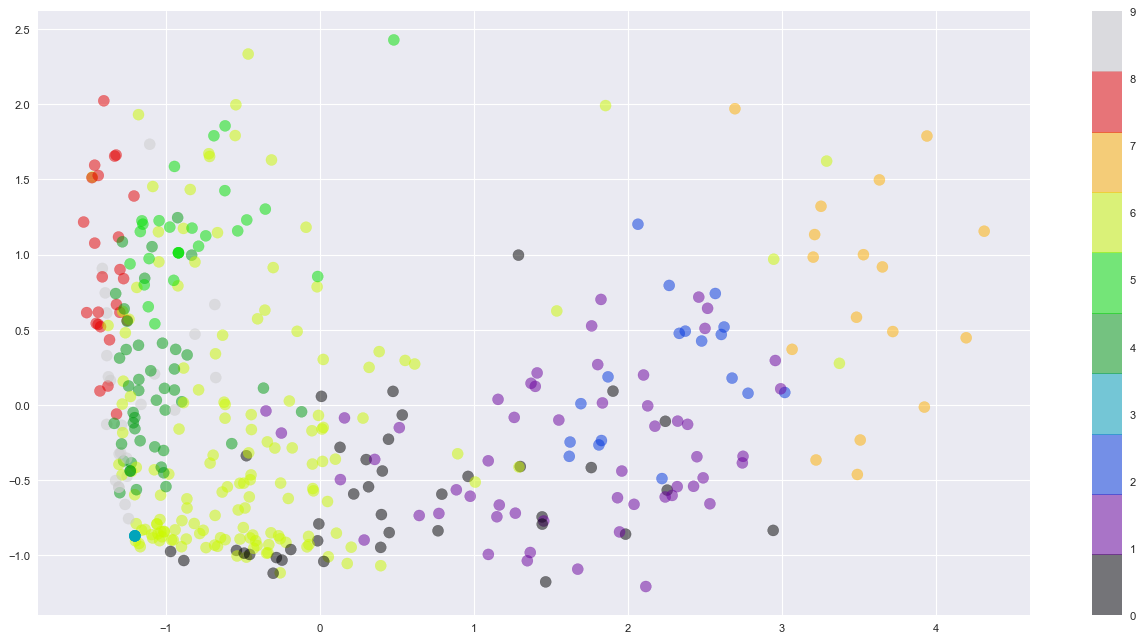

In [144]:
# Spectral clustering | Plot the ego-network in 2 dimensions

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results_df['dim1'], results_df['dim2'], s = 100  ,c= results_df['spectral'], 
            alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

In [145]:
#After looking at top nodes in full ego-network
discover_Friends_toFollow(ids_of_interest = index,
                          friend_list = index, 
                          prop = .5 , count =  20).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at 201 friends' friends:


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
Barack Obama,13,BarackObama,103378627,617663,"Washington, DC",Mar-2007
Stewart Butterfield,12,stewart,82392,2720,West coast,Sep-2006
Robert Scoble,11,Scobleizer,414852,53684,"Campbell, CA",Nov-2006
Anil Dash 🥭,11,anildash,590589,421,NYC,Dec-2006
Medium,11,Medium,2301868,94,"San Francisco, CA, US",May-2012
Nat Friedman,10,natfriedman,38525,2257,San Francisco,Feb-2008
Farhad Manjoo,10,fmanjoo,171163,4333,"California, USA",Mar-2007
jack,10,jack,4109510,3731,,Mar-2006
Dave McClure,9,davemcclure,358417,18011,,Jul-2006


In [146]:
#After looking at Data-Science clustsers (Spectral clustering)
favorite_cluster_df = results_df [results_df['spectral'].isin([0,2,5,8])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = index, 
                          prop = .5, count = 30).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at  54 friends' friends:
... Cache-Miss for 14 nodes. Updating Cache...


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
jack,7,jack,4109510,3731,,Mar-2006
Erick Schonfeld,6,erickschonfeld,75292,1375,New York,Jan-2008
Dave McClure,6,davemcclure,358417,18011,,Jul-2006
marissamayer,6,marissamayer,1656617,350,"San Francisco, CA",Nov-2008
ashton kutcher,5,aplusk,18019499,778,"Los Angeles, California",Jan-2009
Padmasree,5,Padmasree,1467655,207,California,Jun-2008
Kevin Rose ⛩,5,kevinrose,1639998,915,"San Francisco, CA",Jan-2007
John Doerr,5,johndoerr,286903,383,,Feb-2009
Kevin Werbach,5,kwerb,26590,1488,"Philly, USA",Mar-2007


In [147]:
#After looking at Design clustser (Spectral clustering)
discover_Friends_toFollow(ids_of_interest = list(results_df [results_df['spectral'] == 9].index), 
                          friend_list = index, 
                          prop = 1, count = 20).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at  24 friends' friends:
... Cache-Miss for 18 nodes. Updating Cache...


,Freq,UserName,Followers,Friends,Location,Created
FullName,,,,,,
DataRobot,2,DataRobot,12166,3559,"Boston, MA",Jun-2012
Domino Data Lab,2,DominoDataLab,7886,1670,"San Francisco, CA",Sep-2013
Tianqi Chen,2,tqchenml,5141,264,University of Washington,May-2015
ML Hipster,2,ML_Hipster,14122,0,Some local minima,Jul-2012
Factual,2,factual,7456,691,Los Angeles,Feb-2009
Chris DuBois,2,chrisdubois,418,303,"Seattle, WA",Jun-2008
Databricks,2,databricks,26535,79,"San Francisco, CA",Jul-2013
Gil Elbaz,2,gilelbaz,5392,1903,"Los Angeles, CA",Feb-2009
Zoltan Varju,2,zoltanvarju,914,285,"Budapest, Hungary",May-2009
